# MIT XGBoost model (Binary)
 As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling
rescaling: MinMax Scaler
 
If you don't have the original files: run the notebook `preprocessing_mit_binary_shift_minmax_oversampling.ipynb`      

Input file: (The preprocessed data)   
mitbih_binary_train_shift_minmax_oversampling.csv
mitbih_binary_test_shift_minmax_oversampling.csv

Output:   
model_mit_binary_shift_XGBoost.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


# Read Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import numpy as np
import seaborn as sns
import pickle

RawFiles = dict({
    'train': data_path + 'mitbih_multipleclass_train_shift_minmax_oversampling.csv', 
    'test': data_path + 'mitbih_multipleclass_test_shift_minmax_oversampling.csv'  
})

OutputFiles = dict({
    'model': model_output_path +  'model_mit_multiple_shift_XGBoost.pkl',
})


train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [3]:
# check if target has only 2 classes
y_train.value_counts()

target
0.0    72471
1.0    72471
2.0    72471
3.0    72471
Name: count, dtype: int64

In [4]:
# check if target has only 2 classes
y_test.value_counts()

target
0.0    18118
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

# XGBoost Grid Search



c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not u

Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Average F1 Score from Nested Cross-Validation: 0.8427


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 score: 0.8186157544059294


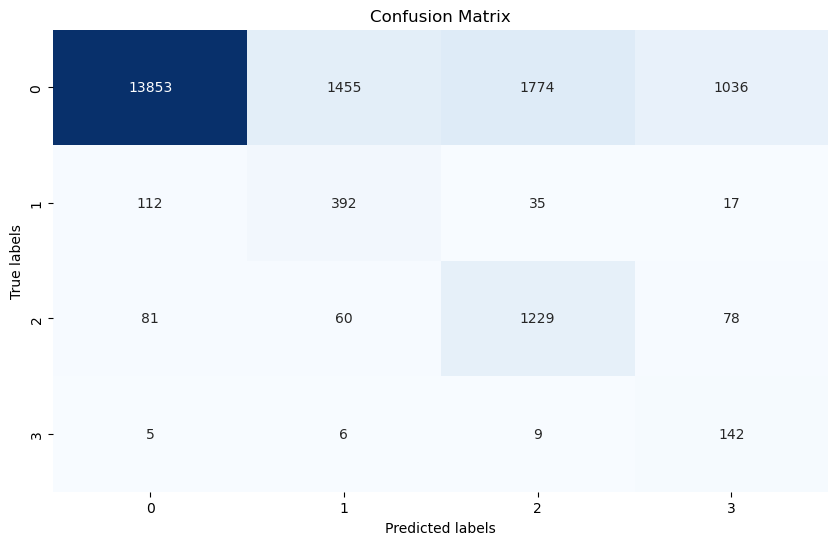

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.76      0.86     18118
         1.0       0.20      0.71      0.32       556
         2.0       0.40      0.85      0.55      1448
         3.0       0.11      0.88      0.20       162

    accuracy                           0.77     20284
   macro avg       0.43      0.80      0.48     20284
weighted avg       0.92      0.77      0.82     20284



In [7]:
# XGBoost model with initial parameters
xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)

# Grid search parameters for XGBoost (simplified to avoid computational overhead)
grid_params = {
    'xgb__n_estimators': [100],  # Number of trees in the forest
    'xgb__max_depth': [3],  # Maximum depth of the tree
    'xgb__learning_rate': [0.1],  # Learning rate
    'xgb__subsample': [0.8],  # Subsample ratio of the training instances
    'xgb__colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree
}

# Inner and outer cross-validation (for nested cross-validation)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline with XGBoost
pipeline = Pipeline([
    ('xgb', xgb)  
])

# Nested cross-validation with grid search
nested_scores = []

for train_index, test_index in outer_cv.split(X_train, y_train):
    X_train_inner, X_test_inner = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_inner, y_test_inner = y_train.iloc[train_index], y_train.iloc[test_index]

    # Grid search with cross-validation
    grid_search = GridSearchCV(pipeline, grid_params, cv=inner_cv, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train_inner, y_train_inner)

    # Best model from the inner grid search
    best_model = grid_search.best_estimator_

    # Model on the outer test set
    y_pred = best_model.predict(X_test_inner)

    # F1 score (macro-averaged for multi-class)
    f1 = f1_score(y_test_inner, y_pred, average='macro')
    nested_scores.append(f1)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Average F1 score from the nested cross-validation
print(f'Average F1 Score from Nested Cross-Validation: {np.mean(nested_scores):.4f}')

# Train the final model on the full training dataset
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)

# Prediction on the test set
y_pred = final_model.predict(X_test)

# F1 score (macro-averaged)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)



In [8]:
# Print the summary
print(f"Best parameters: {best_params}")
print(f"F1 score on the test set: {f1}")

Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
F1 score on the test set: 0.8186157544059294


### Save model

In [9]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file:
    pickle.dump(final_model, model_file)

In [10]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-10 14:25:07.809811
